In [3]:
import pandas as pd
import json

In [4]:
df = pd.read_csv('../data/ExtractedTweets.csv')
df

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...
...,...,...,...
86455,Republican,RepTomPrice,Check out my op-ed on need for End Executive O...
86456,Republican,RepTomPrice,"Yesterday, Betty &amp; I had a great time lear..."
86457,Republican,RepTomPrice,We are forever grateful for the service and sa...
86458,Republican,RepTomPrice,Happy first day of school @CobbSchools! #CobbB...


In [5]:
with open('convert.txt', 'w') as convert_file:
     convert_file.write(json.dumps('../mfd2.0 (1).dic'))

In [6]:
found_df = pd.read_csv('../mfd2.0 (1).dic', sep='\t')
found_df.reset_index(inplace=True)
found_df.columns = ['word', 'foundation']
found_df = found_df.drop(labels=range(0, 11), axis=0)
found_df.head(200)

,word,foundation
11,compassion,1
12,empathy,1
13,kindness,1
14,caring,1
15,generosity,1
...,...,...
206,suffered,2
207,harmful,2
208,inflicted,2
209,mistreat,2


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

def custom_tokenizer(string):
    tokenizer= CountVectorizer(stop_words='english').build_tokenizer()
    tokens = tokenizer(string.lower())
#     lemmitized_tokens = [...]
#     stemmed_tokens = [...]
    return tokens

In [8]:
df['tokens'] = df['Tweet'].map(custom_tokenizer)

In [42]:
# https://towardsdatascience.com/try-texthero-the-absolute-simplest-way-to-clean-and-analyze-text-in-pandas-6db86ed14272
# !pip install texthero
import texthero as hero

In [43]:
df['tokens'] = hero.clean(df['tokens'])

In [ ]:
def remove_words(lst):
    lst = lst.replace('https', '')
    lst = lst.replace('co', '')
    lst = lst.replace('rt', '')
    lst = lst.replace('amp', '')
    return lst

In [ ]:
df['tokens'] = df['tokens'].map(remove_words)

In [48]:
tw = hero.visualization.top_words(df['tokens']).head(20)

import plotly.express as px
fig = px.bar(tw)
fig.show()
tw.head()

today    8732
great    4552
thank    3895
house    3877
tax      3590
Name: tokens, dtype: int64

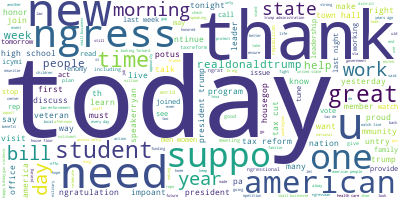

In [49]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['tokens'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [50]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data = df.tokens.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['today', 'senate', 'dems', 'vote', 'savetheinternet', 'proud', 'suppo', 'similar', 'netneutrality', 'legislation', 'house', 'tggdlu']


In [51]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]


In [52]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"today" + 0.005*"trump" + 0.004*"bill" + 0.004*"help" + 0.003*"th" + '
  '0.003*"house" + 0.003*"work" + 0.003*"president" + 0.003*"american" + '
  '0.003*"time"'),
 (1,
  '0.011*"today" + 0.005*"would" + 0.005*"trump" + 0.005*"thank" + '
  '0.004*"house" + 0.004*"us" + 0.004*"bill" + 0.004*"health" + '
  '0.004*"president" + 0.003*"hearing"'),
 (2,
  '0.013*"today" + 0.005*"office" + 0.005*"house" + 0.004*"great" + '
  '0.004*"bipaisan" + 0.004*"new" + 0.004*"day" + 0.004*"one" + 0.003*"trump" '
  '+ 0.003*"act"'),
 (3,
  '0.007*"house" + 0.004*"work" + 0.004*"bill" + 0.004*"tax" + '
  '0.004*"president" + 0.003*"office" + 0.003*"trump" + 0.003*"ngress" + '
  '0.003*"senate" + 0.003*"hall"'),
 (4,
  '0.005*"time" + 0.004*"new" + 0.004*"suppo" + 0.004*"students" + '
  '0.004*"proud" + 0.004*"working" + 0.004*"tax" + 0.004*"last" + '
  '0.004*"today" + 0.003*"mmunity"'),
 (5,
  '0.006*"today" + 0.006*"thank" + 0.005*"happy" + 0.005*"family" + '
  '0.004*"new" + 0.004*"th" 

In [61]:
import pickle 
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('../results/ldavis_prepared_'+str(num_topics))

# this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = pyLDAvis.sklearn.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

# LDAvis_prepared

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [26]:
#https://stackoverflow.com/questions/30926670/add-multiple-empty-columns-to-pandas-dataframe
# df.reindex(columns=[*df.columns.to_list(), '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], fill_value=0)


In [17]:
# Use w2v on the tokens columns to find the words. Then create 2000 columns, 1 for each word I'm looking for. Add a count to the column if the word is in the text.
# Then maybe count up the number for each foundation after that

In [2]:
# Import Word2Vec
from gensim.models.word2vec import Word2Vec

# If you want to use gensim's data, import their downloader
# and load it.

import gensim.downloader as api
corpus = api.load('text8')

# If you have your own iterable corpus of cleaned data, you can 
# read it in as corpus and pass that in.

# Train a model! 
model = Word2Vec(corpus,      # Corpus of data.
                 size=100,    # How many dimensions do you want in your word vector?
                 window=5,    # How many "context words" do you want?
                 min_count=1, # Ignores words below this threshold.
                 sg=1,        # SG = 1 uses SkipGram, SG = 0 uses CBOW (default).
                 workers=4)   # Number of "worker threads" to use (parallelizes process).



In [72]:
# Do what you'd like to do with your data!
model.train(df['tokens'],
           total_examples=model.corpus_count,
           epochs=10)

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(57767953, 75367250)

In [73]:
model.save('../results/w2v_model.pkl')

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Train using gensim corpus then find the vectors of the words I'm looking for in the MFD and find those in model
# 1) Use the word to vec and lda to identify themes and word embeddings, train a model to predict for democrat and republican..
# 2) Hard code the search for terms and figure out how to get the common foundations people fit into and test the accuracy of each model against each other.

